In [2]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent.parent
sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import re

def load_uji_word_format(path):
    data = {}
    current_label = None

    with open(path, "r", encoding="latin-1") as f:
        for line in f:
            line = line.strip()

            if not line or line.startswith("//"):
                continue

            if line.startswith("WORD"):
                parts = line.split()
                current_label = parts[1]
                data.setdefault(current_label, [])

            elif line.startswith("POINTS"):
                numbers = line.split("#", 1)[1].strip().split()
                coords = list(map(float, numbers))
                traj = np.array(coords).reshape(-1, 2)
                data[current_label].append(traj)

    return data



In [3]:
data = load_uji_word_format("C:/Users/halac/Desktop/MVA/Time-Series-for-ML/timeseries-dtw-gi/src/data/ujipenchars2.txt")

print(sorted(data.keys())[:10])   # available letters
print(len(data['a']))             # number of 'a' samples
print(data['a'][0].shape)         # (T, 2)

['!', '"', '$', '%', "'", '(', ')', ',', '-', '.']
122
(44, 2)


In [4]:
def resample_trajectory(traj: np.ndarray, T: int) -> np.ndarray:
    """
    Resample a 2D trajectory to T points using arc-length parametrization.
    traj: (N,2)
    returns: (T,2)
    """
    diffs = np.diff(traj, axis=0)
    dists = np.linalg.norm(diffs, axis=1)
    arc = np.concatenate([[0], np.cumsum(dists)])
    arc /= arc[-1]

    new_arc = np.linspace(0, 1, T)
    resampled = np.zeros((T, traj.shape[1]))

    for d in range(traj.shape[1]):
        resampled[:, d] = np.interp(new_arc, arc, traj[:, d])

    return resampled


def normalize_trajectory(traj: np.ndarray) -> np.ndarray:
    """
    Center and scale trajectory.
    """
    traj = traj - traj.mean(axis=0, keepdims=True)
    scale = np.sqrt((traj**2).sum() / traj.shape[0])
    return traj / (scale + 1e-8)



In [7]:
# select letter
letter = 'g'
raw_trajs = data[letter]

T = 50   # very good choice for letters
dataset = []

for traj in raw_trajs:
    traj_rs = resample_trajectory(traj, T)
    traj_norm = normalize_trajectory(traj_rs)
    dataset.append(traj_norm)

print(len(dataset), dataset[0].shape)  # (n_samples, (T,2))


124 (50, 2)


In [6]:
import numpy
import torch
import torch.optim as optim
import geoopt
import warnings
from scipy.interpolate import interp1d
from sklearn.exceptions import ConvergenceWarning
from tslearn.utils import to_time_series, ts_size
from tslearn.metrics import dtw_path
import scipy

def path2mat(path):
    max0, max1 = path[-1]
    w_pi = np.zeros((max0 + 1, max1 + 1))
    for i, j in path:
        w_pi[i, j] = 1.
    return w_pi

EPSILON = 1e-6

def dtw_gi(ts0, ts1, init_p=None, max_iter=20, return_matrix=False,
           verbose=False, use_bias=False):
    r"""Compute Dynamic Time Warping with Global Invariance (DTW-GI) similarity
    measure between (possibly multidimensional) time series and return it.
    DTW-GI is computed as the Euclidean distance between aligned+rotated time
    series, i.e.:

    .. math::
        DTW-GI(X, Y) = \min_{P \in V_{d_0, d_1}} \min_{\Pi}
                        \sqrt{\sum_{(i, j) \in \Pi} \|X_{i} - Y_{j} P^T \|^2}
        
    It is not required that both time series share the same size, nor the same 
    dimension. DTW was originally presented in [1]_.
    
    Parameters
    ----------
    ts0: array of shape (sz0, d0)
        A time series.
        
    ts1: array of shape (sz1, d1)
        A time series.
        
    init_p : array of shape (d0, d1) (default: None)
        Initial p matrix for the Stiefel linear map. If None, identity matrix
        is used.
        
    max_iter : int (default: 20)
        Number of iterations for the iterative optimization algorithm.
    
    return_matrix : boolean (default: False)
        Whether the warping matrix should be returned in place of the path.
    
    verbose: boolean (default: True)
        Whether information should be printed during optimization

    use_bias: boolean (default: False)
        If True, the feature space map is affine, otherwise it is linear.
        
    Returns
    -------
    w_pi or path
        Warping matrix (binary matrix of shape (sz0, sz1) or path (list of
        index pairs)
        
    p
        Stiefel matrix
        
    cost
        Similarity score
    
    References
    ----------
    .. [1] H. Sakoe, S. Chiba, "Dynamic programming algorithm optimization for
           spoken word recognition," IEEE Transactions on Acoustics, Speech and
           Signal Processing, vol. 26(1), pp. 43--49, 1978.
    """
    ts0_ = to_time_series(ts0, remove_nans=True)
    ts1_ = to_time_series(ts1, remove_nans=True)

    sz0, d0 = ts0_.shape
    sz1, d1 = ts1_.shape

    ts0_m = ts0_.mean(axis=0).reshape((-1, 1))
    ts1_m = ts1_.mean(axis=0).reshape((-1, 1))

    w_pi = np.zeros((sz0, sz1))
    if init_p is None:
        p = np.eye(d0, d1)
    else:
        p = init_p
    bias = np.zeros((d0, 1))

    # BCD loop
    for iter in range(1, max_iter + 1):
        w_pi_old = w_pi
        # Temporal alignment
        path, cost = dtw_path(ts0_, ts1_.dot(p.T) + bias.T)
        if verbose:
            print("Iteration {}: DTW cost: {:.3f}".format(iter, cost))
        w_pi = path2mat(path)
        if np.allclose(w_pi, w_pi_old):
            break
        # Feature space registration
        if use_bias:
            m = (ts0_.T - ts0_m).dot(w_pi).dot(ts1_ - ts1_m.T)
        else:
            m = (ts0_.T).dot(w_pi).dot(ts1_)
        u, sigma, vt = scipy.linalg.svd(m, full_matrices=False)
        p = u.dot(vt)
        if use_bias:
            bias = ts0_m - ts1_m.T.dot(p.T).T
    path, cost = dtw_path(ts0_, ts1_.dot(p.T) + bias.T)
    if verbose:
        print("After optimization: DTW cost: {:.3f}".format(cost))
    if use_bias:
        if return_matrix:
            return w_pi, p, bias, cost
        else:
            return path, p, bias, cost
    else:
        if return_matrix:
            return w_pi, p, cost
        else:
            return path, p, cost
        

def dtw_gi_barycenter_averaging(X, barycenter_size=None,
                                init_barycenter=None,
                                max_iter=30, tol=1e-5, weights=None,
                                metric_params=None,
                                keep_p_matrices=False,
                                verbose=False, n_init=3):
    """DTW-GI Barycenter Averaging (DBA) method estimated through
    Expectation-Maximization algorithm.

    DBA was originally presented in [1]_.
    This implementation is based on a idea from [2]_ (Majorize-Minimize Mean
    Algorithm).

    Parameters
    ----------
    X : array-like, shape=(n_ts, sz, d)
        Time series dataset.

    barycenter_size : int or None (default: None)
        Size of the barycenter to generate. If None, the size of the barycenter
        is that of the data provided at fit
        time or that of the initial barycenter if specified.

    init_barycenter : array or None (default: None)
        Initial barycenter to start from for the optimization process.

    max_iter : int (default: 30)
        Number of iterations of the Expectation-Maximization optimization
        procedure.

    tol : float (default: 1e-5)
        Tolerance to use for early stopping: if the decrease in cost is lower
        than this value, the
        Expectation-Maximization procedure stops.

    weights: None or array
        Weights of each X[i]. Must be the same size as len(X).
        If None, uniform weights are used.

    metric_params: dict or None (default: None)
        DTW constraint parameters to be used.
        See :ref:`tslearn.metrics.dtw_path <fun-tslearn.metrics.dtw_path>` for
        a list of accepted parameters
        If None, no constraint is used for DTW computations.

    keep_p_matrices: bool (default: False)
        Whether P matrices from previous iteration should be used to initialize
        P matrices for the current iteration

    verbose : boolean (default: False)
        Whether to print information about the cost at each iteration or not.

    n_init : int (default: 3)
        Number of different initializations to try

    Returns
    -------
    numpy.array of shape (barycenter_size, d) or (sz, d) if barycenter_size \
            is None
        DBA barycenter of the provided time series dataset.

    float
        Corresponding cost (weighted sum of alignement costs)

    References
    ----------
    .. [1] F. Petitjean, A. Ketterlin & P. Gancarski. A global averaging method
       for dynamic time warping, with applications to clustering. Pattern
       Recognition, Elsevier, 2011, Vol. 44, Num. 3, pp. 678-693

    .. [2] D. Schultz and B. Jain. Nonsmooth Analysis and Subgradient Methods
       for Averaging in Dynamic Time Warping Spaces.
       Pattern Recognition, 74, 340-358.
    """
    best_cost = numpy.inf
    best_barycenter = None
    for i in range(n_init):
        if verbose:
            print("Attempt {}".format(i + 1))
        bary, loss = dtw_gi_barycenter_averaging_one_init(
            X=X,
            barycenter_size=barycenter_size,
            init_barycenter=init_barycenter,
            max_iter=max_iter,
            tol=tol,
            weights=weights,
            metric_params=metric_params,
            keep_p_matrices=keep_p_matrices,
            verbose=verbose
        )
        if loss < best_cost:
            best_cost = loss
            best_barycenter = bary
    return best_barycenter, best_cost


def dtw_gi_barycenter_averaging_one_init(X, barycenter_size=None,
                                         init_barycenter=None,
                                         max_iter=30, tol=1e-5, weights=None,
                                         metric_params=None,
                                         keep_p_matrices=False,
                                         verbose=False):
    """DTW-GI Barycenter Averaging (DBA) method estimated through
    Expectation-Maximization algorithm.

    DBA was originally presented in [1]_.
    This implementation is based on a idea from [2]_ (Majorize-Minimize Mean
    Algorithm).

    Here, the transform is of the form x -> Ax + b where A lies on the Stiefel
    manifold.

    Parameters
    ----------
    X : array-like, shape=(n_ts, sz, d)
        Time series dataset.

    barycenter_size : int or None (default: None)
        Size of the barycenter to generate. If None, the size of the barycenter
        is that of the data provided at fit
        time or that of the initial barycenter if specified.

    init_barycenter : array or None (default: None)
        Initial barycenter to start from for the optimization process.

    max_iter : int (default: 30)
        Number of iterations of the Expectation-Maximization optimization
        procedure.

    tol : float (default: 1e-5)
        Tolerance to use for early stopping: if the decrease in cost is lower
        than this value, the
        Expectation-Maximization procedure stops.

    weights: None or array
        Weights of each X[i]. Must be the same size as len(X).
        If None, uniform weights are used.

    metric_params: dict or None (default: None)
        DTW constraint parameters to be used.
        See :ref:`tslearn.metrics.dtw_path <fun-tslearn.metrics.dtw_path>` for
        a list of accepted parameters
        If None, no constraint is used for DTW computations.

    keep_p_matrices: bool (default: False)
        Whether P matrices from previous iteration should be used to initialize
        P matrices for the current iteration

    verbose : boolean (default: False)
        Whether to print information about the cost at each iteration or not.

    Returns
    -------
    numpy.array of shape (barycenter_size, d) or (sz, d) if barycenter_size \
            is None
        DBA barycenter of the provided time series dataset.

    float
        Corresponding cost (weighted sum of alignement costs)

    References
    ----------
    .. [1] F. Petitjean, A. Ketterlin & P. Gancarski. A global averaging method
       for dynamic time warping, with applications to clustering. Pattern
       Recognition, Elsevier, 2011, Vol. 44, Num. 3, pp. 678-693

    .. [2] D. Schultz and B. Jain. Nonsmooth Analysis and Subgradient Methods
       for Averaging in Dynamic Time Warping Spaces.
       Pattern Recognition, 74, 340-358.
    """
    X_ = [to_time_series(Xi, remove_nans=True) for Xi in X]
    if barycenter_size is None:
        barycenter_size = ts_size(X_[0])
    weights = _set_weights(weights, len(X_))
    if init_barycenter is None:
        try:
            barycenter = _init_avg(X_, barycenter_size)
        except:
            barycenter_idx = numpy.random.choice(len(X_))
            barycenter = X_[barycenter_idx]
    else:
        barycenter = init_barycenter
    cost_prev, cost = numpy.inf, numpy.inf
    list_p = [numpy.eye(Xi.shape[1], barycenter.shape[1]).T for Xi in X_]
    for it in range(max_iter):
        if not keep_p_matrices:
            list_p = None
        list_w_pi, list_p, list_bias, cost = _mm_assignment(
            X_,
            barycenter,
            weights,
            list_init_p=list_p,
            metric_params=metric_params
        )
        diag_sum_v_k, list_w_k = _mm_valence_warping(list_w_pi, weights)
        if verbose:
            print("[DBA] epoch %d, cost: %.3f" % (it + 1, cost))
        rotated_x = [numpy.empty(Xi.shape) for Xi in X_]
        for i in range(len(X_)):
            rotated_x[i] = X_[i].dot(list_p[i].T) + list_bias[i].T
        barycenter = _mm_update_barycenter(rotated_x, diag_sum_v_k, list_w_k)
        if abs(cost_prev - cost) < tol:
            break
        elif cost_prev < cost:
            warnings.warn("DBA loss is increasing while it should not be. "
                          "Stopping optimization.", ConvergenceWarning)
            break
        else:
            cost_prev = cost
    return barycenter, cost


def _set_weights(w, n):
    """Return w if it is a valid weight vector of size n, and a vector of n 1s
    otherwise.
    """
    if w is None or len(w) != n:
        w = numpy.ones((n,))
    return w


def _init_avg(X, barycenter_size):
    if ts_size(X[0]) == barycenter_size:
        return numpy.nanmean(X, axis=0)
    else:
        X_avg = numpy.nanmean(X, axis=0)
        xnew = numpy.linspace(0, 1, barycenter_size)
        f = interp1d(numpy.linspace(0, 1, X_avg.shape[0]), X_avg,
                     kind="linear", axis=0)
        return f(xnew)


def _mm_assignment(X, barycenter, weights, list_init_p=None,
                   metric_params=None):
    """Computes item assignement based on DTW alignments and return cost as a
    bonus.

    Parameters
    ----------
    X : numpy.array of shape (n, sz, d)
        Time-series to be averaged

    barycenter : numpy.array of shape (barycenter_size, d)
        Barycenter as computed at the current step of the algorithm.

    weights: array
        Weights of each X[i]. Must be the same size as len(X).

    list_init_p: list of arrays of shape (d, d)
        Initial P matrices

    metric_params: dict or None (default: None)
        Key-value parameters for f_dtw

    Returns
    -------
    list_W_pi
        List of warping matrices

    list_p
        List of mapping matrices

    float
        Current alignment cost
    """
    if metric_params is None:
        metric_params = {}
    n = len(X)
    if list_init_p is None:
        list_init_p = [numpy.eye(Xi.shape[1], barycenter.shape[1]).T
                       for Xi in X]
    cost = 0.
    list_w_pi = []
    list_p = []
    list_bias = []
    for i in range(n):
        w_pi, p_i, bias_i, dist_i = dtw_gi(barycenter, X[i],
                                           init_p=list_init_p[i],
                                           return_matrix=True,
                                           use_bias=True,
                                           **metric_params)
        cost += dist_i ** 2 * weights[i]
        list_w_pi.append(w_pi)
        list_p.append(p_i)
        list_bias.append(bias_i)
    cost /= weights.sum()
    return list_w_pi, list_p, list_bias, cost


def _subgradient_valence_warping(list_w_pi, weights):
    """Compute Valence and Warping matrices from paths.

    Valence matrices are denoted :math:`V^{(k)}` and Warping matrices are
    :math:`W^{(k)}` in [1]_.

    This function returns a list of :math:`V^{(k)}` diagonals (as a vector)
    and a list of :math:`W^{(k)}` matrices.

    Parameters
    ----------
    list_w_pi : list of arrays of shape (sz_bar, sz_i)
        List of warping matrices

    weights: array
        Weights of each X[i]. Must be the same size as len(X).

    Returns
    -------
    list of numpy.array of shape (barycenter_size, )
        list of weighted :math:`V^{(k)}` diagonals (as a vector)

    list of numpy.array of shape (barycenter_size, sz_k)
        list of weighted :math:`W^{(k)}` matrices

    References
    ----------

    .. [1] D. Schultz and B. Jain. Nonsmooth Analysis and Subgradient Methods
       for Averaging in Dynamic Time Warping Spaces.
       Pattern Recognition, 74, 340-358.
    """
    list_v_k = []
    list_w_k = []
    for k, w_pi in enumerate(list_w_pi):
        list_w_k.append(w_pi * weights[k])
        list_v_k.append(w_pi.sum(axis=1) * weights[k])
    return list_v_k, list_w_k


def _mm_valence_warping(list_w_pi, weights):
    """Compute Valence and Warping matrices from paths.

    Valence matrices are denoted :math:`V^{(k)}` and Warping matrices are
    :math:`W^{(k)}` in [1]_.

    This function returns the sum of :math:`V^{(k)}` diagonals (as a vector)
    and a list of :math:`W^{(k)}` matrices.

    Parameters
    ----------
    list_w_pi : list of arrays of shape (sz_bar, sz_i)
        list of Warping matrices

    barycenter_size : int
        Size of the barycenter to generate.

    weights: array
        Weights of each X[i]. Must be the same size as len(X).

    Returns
    -------
    numpy.array of shape (barycenter_size, )
        sum of weighted :math:`V^{(k)}` diagonals (as a vector)

    list of numpy.array of shape (barycenter_size, sz_k)
        list of weighted :math:`W^{(k)}` matrices

    References
    ----------

    .. [1] D. Schultz and B. Jain. Nonsmooth Analysis and Subgradient Methods
       for Averaging in Dynamic Time Warping Spaces.
       Pattern Recognition, 74, 340-358.
    """
    list_v_k, list_w_k = _subgradient_valence_warping(
        list_w_pi=list_w_pi,
        weights=weights)
    diag_sum_v_k = numpy.zeros(list_v_k[0].shape)
    for v_k in list_v_k:
        diag_sum_v_k += v_k
    return diag_sum_v_k, list_w_k


def _mm_update_barycenter(X, diag_sum_v_k, list_w_k):
    """Update barycenters using the formula from Algorithm 2 in [1]_.

    Parameters
    ----------
    X : numpy.array of shape (n, sz, d)
        Time-series to be averaged

    diag_sum_v_k : numpy.array of shape (barycenter_size, )
        sum of weighted :math:`V^{(k)}` diagonals (as a vector)

    list_w_k : list of numpy.array of shape (barycenter_size, sz_k)
        list of weighted :math:`W^{(k)}` matrices

    Returns
    -------
    numpy.array of shape (barycenter_size, d)
        Updated barycenter

    References
    ----------

    .. [1] D. Schultz and B. Jain. Nonsmooth Analysis and Subgradient Methods
       for Averaging in Dynamic Time Warping Spaces.
       Pattern Recognition, 74, 340-358.
    """
    d = X[0].shape[-1]
    barycenter_size = diag_sum_v_k.shape[0]
    sum_w_x = numpy.zeros((barycenter_size, d))
    for k, (w_k, x_k) in enumerate(zip(list_w_k, X)):
        sum_w_x += w_k.dot(x_k[:ts_size(x_k)])
    barycenter = numpy.diag(1. / diag_sum_v_k).dot(sum_w_x)
    return barycenter


def normalize_tensor(w):
    return w / (torch.norm(w) + EPSILON)


def nanmean(losses):
    s = 0.
    n = 0
    for l in losses:
        if not torch.isnan(l):
            s += l
            n += 1
    return s / n

In [6]:
list_barycenter_fun = [
    lambda dataset, sz, b: dtw_gi_barycenter_averaging(dataset,
                                                       init_barycenter=b,
                                                       barycenter_size=sz,
                                                       verbose=False,
                                                       n_init=3,
                                                       max_iter=1000,
                                                       keep_p_matrices=True,
                                                       metric_params={
                                                           "max_iter": 1000
                                                       })[0]
]
list_method_names = ["DTW-GI"]

In [8]:
sz_barycenter = 30
d_barycenter = 2
init_b = np.random.randn(sz_barycenter, d_barycenter)

for i, (barycenter_fun, title) in enumerate(zip(list_barycenter_fun,
                                                    list_method_names)):
        init_b = np.random.randn(sz_barycenter, d_barycenter)
        barycenter = barycenter_fun(dataset, sz_barycenter, init_b)

C:\Users\halac\AppData\Local\Temp\ipykernel_10132\3839217915.py:331: ConvergenceWarning: DBA loss is increasing while it should not be. Stopping optimization.
  warnings.warn("DBA loss is increasing while it should not be. "


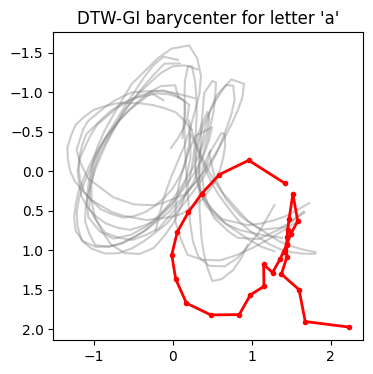

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))

# plot some samples
for x in dataset[:10]:
    plt.plot(x[:,0], x[:,1], color="gray", alpha=0.4)

# plot barycenter
b = barycenter
plt.plot(b[:,0], b[:,1], '-o', color="red", lw=2, ms=3)

plt.axis("equal")
plt.gca().invert_yaxis()
plt.title(f"DTW-GI barycenter for letter '{letter}'")
plt.show()

In [10]:
from dtw_gi import SoftDTWGIBarycenter

bary = SoftDTWGIBarycenter(
    T=T,
    p=2,             
    gamma=0.5,        
    max_iter=30,
    lr_b=5e-2,       
)

res = bary.fit(dataset[:10], verbose=True)


[Barycenter-GI] iter=001 | loss=5.754254
[Barycenter-GI] iter=002 | loss=5.337111
[Barycenter-GI] iter=003 | loss=5.049353
[Barycenter-GI] iter=004 | loss=4.844837
[Barycenter-GI] iter=005 | loss=4.696790
[Barycenter-GI] iter=006 | loss=4.588422
[Barycenter-GI] iter=007 | loss=4.508545
[Barycenter-GI] iter=008 | loss=4.449385
[Barycenter-GI] iter=009 | loss=4.405396
[Barycenter-GI] iter=010 | loss=4.372557
[Barycenter-GI] iter=011 | loss=4.347932
[Barycenter-GI] iter=012 | loss=4.329366
[Barycenter-GI] iter=013 | loss=4.315273
[Barycenter-GI] iter=014 | loss=4.304488
[Barycenter-GI] iter=015 | loss=4.296154
[Barycenter-GI] iter=016 | loss=4.289640
[Barycenter-GI] iter=017 | loss=4.284482
[Barycenter-GI] iter=018 | loss=4.280338
[Barycenter-GI] iter=019 | loss=4.276957
[Barycenter-GI] iter=020 | loss=4.274153
[Barycenter-GI] iter=021 | loss=4.271789
[Barycenter-GI] iter=022 | loss=4.269763
[Barycenter-GI] iter=023 | loss=4.268000
[Barycenter-GI] iter=024 | loss=4.266442
[Barycenter-GI] 

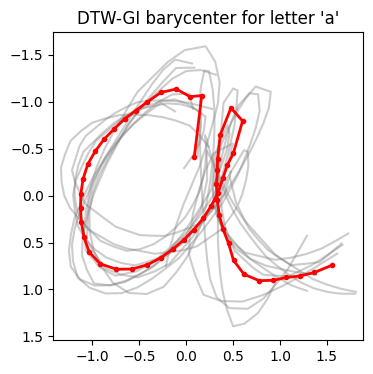

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))

# plot some samples
for x in dataset[:10]:
    plt.plot(x[:,0], x[:,1], color="gray", alpha=0.4)

# plot barycenter
b = res.barycenter
plt.plot(b[:,0], b[:,1], '-o', color="red", lw=2, ms=3)

plt.axis("equal")
plt.gca().invert_yaxis()
plt.title(f"DTW-GI barycenter for letter '{letter}'")
plt.show()

In [15]:
a_data = dataset
bary_a = b

In [8]:
# select letter
letter = 'g'
raw_trajs = data[letter]

T = 50   # very good choice for letters
dataset = []

for traj in raw_trajs:
    traj_rs = resample_trajectory(traj, T)
    traj_norm = normalize_trajectory(traj_rs)
    dataset.append(traj_norm)

print(len(dataset), dataset[0].shape)  # (n_samples, (T,2))

124 (50, 2)


In [9]:
def rotation_matrix(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)],
    ])

angles = np.linspace(-np.pi / 3, np.pi / 3, len(dataset))

dataset_rot = []
for x, theta in zip(dataset, angles):
    R = rotation_matrix(theta)
    dataset_rot.append(x @ R.T)


In [10]:
rng = np.random.default_rng(seed=42)

idx = rng.choice(len(dataset_rot), size=5, replace=False)
dataset_5 = [dataset_rot[i] for i in idx]



In [136]:
rng = np.random.default_rng(seed=42)

idx = rng.choice(len(dataset), size=5, replace=False)
dataset_5 = [dataset[i] for i in idx]

angles = np.linspace(0, np.pi, len(dataset_5))

dataset_rot = []
for x, theta in zip(dataset_5, angles):
    R = rotation_matrix(theta)
    dataset_rot.append(x @ R.T)

In [11]:
bary_dtw_gi_g = dtw_gi_barycenter_averaging(dataset_5)

In [12]:
from tslearn.barycenters import dtw_barycenter_averaging, softdtw_barycenter

bary_g_dtw = dtw_barycenter_averaging(dataset_5)

bary_soft_g = softdtw_barycenter(dataset_5, gamma=0.5)

c:\Users\halac\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\bases\bases.py:16: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [125]:
from tslearn.barycenters import dtw_barycenter_averaging, softdtw_barycenter

bary_e_dtw = dtw_barycenter_averaging(dataset_rot)

bary_soft_e = softdtw_barycenter(dataset_rot, gamma=0.5)

In [13]:
from dtw_gi import SoftDTWGIBarycenter


bary = SoftDTWGIBarycenter(
    T=T,
    p=2,             
    gamma=0.5,        
    max_iter=50,
    lr_b=5e-2,       
)

res = bary.fit(dataset_5, verbose=True)


[Barycenter-GI] iter=001 | loss=14.832050
[Barycenter-GI] iter=002 | loss=12.181012
[Barycenter-GI] iter=003 | loss=10.371613
[Barycenter-GI] iter=004 | loss=9.124869
[Barycenter-GI] iter=005 | loss=8.250961
[Barycenter-GI] iter=006 | loss=7.623822
[Barycenter-GI] iter=007 | loss=7.163687
[Barycenter-GI] iter=008 | loss=6.820431
[Barycenter-GI] iter=009 | loss=6.561438
[Barycenter-GI] iter=010 | loss=6.364456
[Barycenter-GI] iter=011 | loss=6.213697
[Barycenter-GI] iter=012 | loss=6.097672
[Barycenter-GI] iter=013 | loss=6.007893
[Barycenter-GI] iter=014 | loss=5.938034
[Barycenter-GI] iter=015 | loss=5.883359
[Barycenter-GI] iter=016 | loss=5.840304
[Barycenter-GI] iter=017 | loss=5.806180
[Barycenter-GI] iter=018 | loss=5.778950
[Barycenter-GI] iter=019 | loss=5.757067
[Barycenter-GI] iter=020 | loss=5.739350
[Barycenter-GI] iter=021 | loss=5.724895
[Barycenter-GI] iter=022 | loss=5.713009
[Barycenter-GI] iter=023 | loss=5.703157
[Barycenter-GI] iter=024 | loss=5.694922
[Barycenter-G

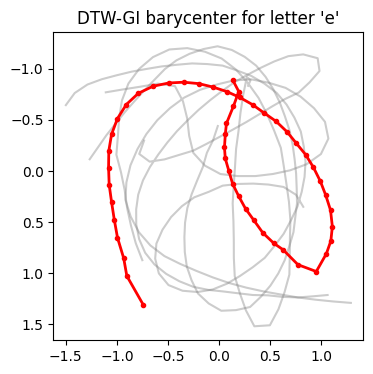

In [133]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))

# plot some samples
for x in dataset_rot:
    plt.plot(x[:,0], x[:,1], color="gray", alpha=0.4)

# plot barycenter
b = res.barycenter
plt.plot(b[:,0], b[:,1], '-o', color="red", lw=2, ms=3)

plt.axis("equal")
plt.gca().invert_yaxis()
plt.title(f"DTW-GI barycenter for letter '{letter}'")
plt.show()

e_data = dataset_rot
bary_e = b

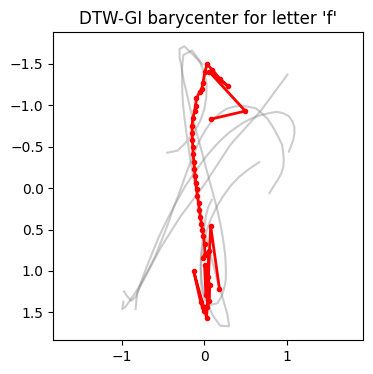

In [93]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))

# plot some samples
for x in dataset_5:
    plt.plot(x[:,0], x[:,1], color="gray", alpha=0.4)

# plot barycenter
b = res.barycenter
plt.plot(b[:,0], b[:,1], '-o', color="red", lw=2, ms=3)

plt.axis("equal")
plt.gca().invert_yaxis()
plt.title(f"DTW-GI barycenter for letter '{letter}'")
plt.show()

f_data = dataset_5
bary_f = b

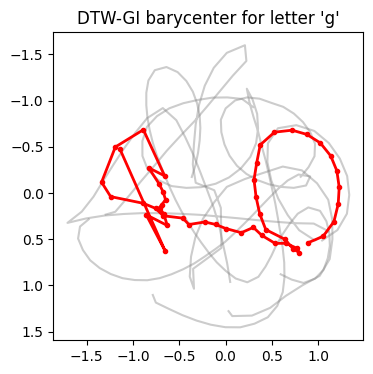

In [140]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))

# plot some samples
for x in dataset_rot:
    plt.plot(x[:,0], x[:,1], color="gray", alpha=0.4)

# plot barycenter
b = res.barycenter
plt.plot(b[:,0], b[:,1], '-o', color="red", lw=2, ms=3)

plt.axis("equal")
plt.gca().invert_yaxis()
plt.title(f"DTW-GI barycenter for letter '{letter}'")
plt.show()

g_data = dataset_rot
bary_g = b

In [111]:
import matplotlib.pyplot as plt
import numpy as np

def plot_samples_and_barycenters(
    samples,
    bary_dtw,
    bary_dtw_gi,
    bary_softdtw,
    bary_softdtw_gi,
    title_samples="Rotated samples",
):
    """
    samples: list of (T,2) arrays (length = 5)
    bary_*: (T,2) arrays
    """

    n = len(samples)
    T = bary_softdtw_gi.shape[0]

    # collect all curves for common limits
    all_curves = samples + [bary_dtw, bary_softdtw, bary_softdtw_gi]
    xs = np.concatenate([c[:, 0] for c in all_curves])
    ys = np.concatenate([c[:, 1] for c in all_curves])

    pad = 0.1
    xlim = (xs.min() - pad, xs.max() + pad)
    ylim = (ys.min() - pad, ys.max() + pad)

    fig, axes = plt.subplots(1, n + 4, figsize=(18, 3))

    # ---- samples
    for i, (ax, x) in enumerate(zip(axes[:n], samples)):
        ax.plot(x[:, 0], x[:, 1], lw=2.0, color="0.4")
        ax.set_title(f"sample {i+1}", fontsize=10)
        ax.set_aspect("equal")
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.invert_yaxis()
        ax.axis("off")

    axes[0].set_ylabel(title_samples, fontsize=11)

    # ---- barycenter plotting helper
    def _plot_bary(ax, bary, title, color):
        t = np.linspace(0, 1, bary.shape[0])
        ax.scatter(
            bary[:, 0], bary[:, 1],
            c=t, cmap="turbo",
            s=28, zorder=3
        )
        ax.plot(
            bary[:, 0], bary[:, 1],
            lw=3.0, color=color, zorder=4
        )
        ax.set_title(title, fontsize=10)
        ax.set_aspect("equal")
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.invert_yaxis()
        ax.axis("off")

    # ---- barycenters
    _plot_bary(axes[n],   bary_dtw,        "DTW barycenter",       "#000000")
    _plot_bary(axes[n+1], bary_softdtw,    "softDTW barycenter",   "#1f77b4")
    _plot_bary(axes[n+2], bary_dtw_gi, "DTW-GI barycenter","#077053")
    _plot_bary(axes[n+3], bary_softdtw_gi, "softDTW-GI barycenter","#87072d")

    plt.tight_layout()
    plt.show()


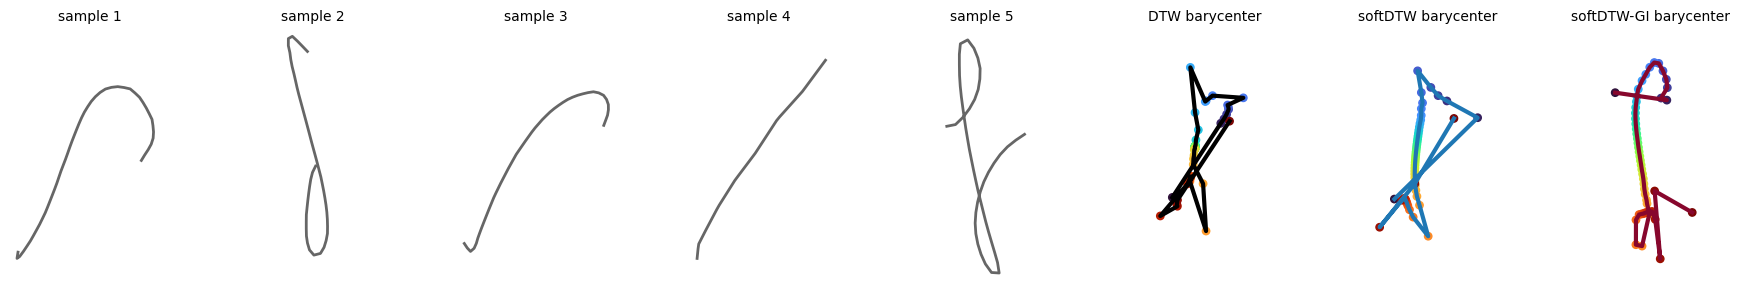

In [91]:
plot_samples_and_barycenters(
    samples=f_data,
    bary_dtw=bary_f_dtw,
    bary_softdtw=bary_soft_f,
    bary_softdtw_gi=bary_f,
)


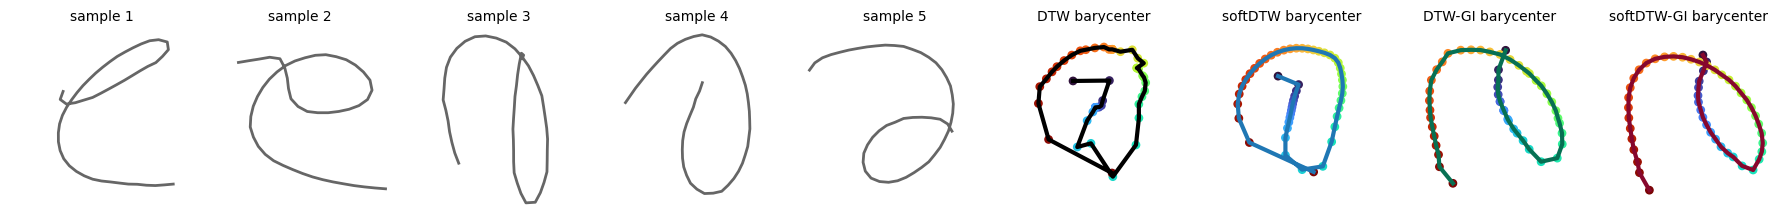

In [134]:
plot_samples_and_barycenters(
    samples=e_data,
    bary_dtw_gi=bary_dtw_gi_e[0],
    bary_dtw=bary_e_dtw,
    bary_softdtw=bary_soft_e,
    bary_softdtw_gi=bary_e,
)


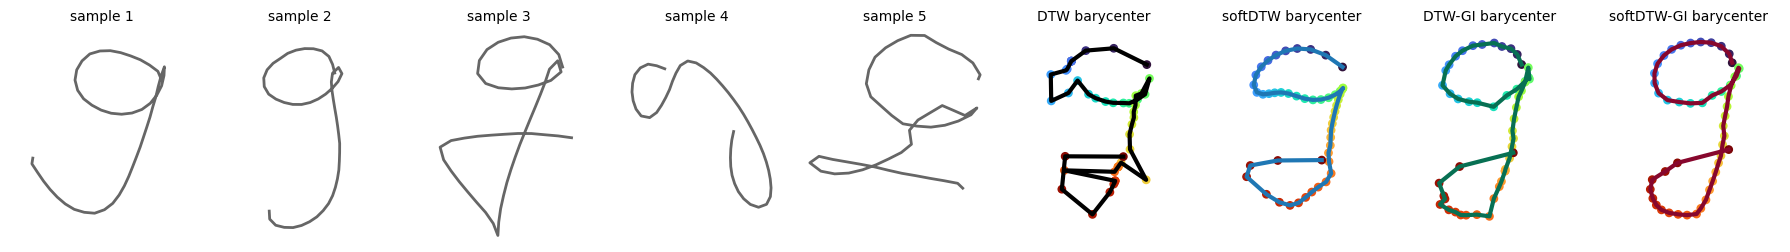

In [112]:
plot_samples_and_barycenters(
    samples=dataset_5,
    bary_dtw_gi=bary_dtw_gi_g[0],
    bary_dtw=bary_g_dtw,
    bary_softdtw=bary_soft_g,
    bary_softdtw_gi=bary_g,
)


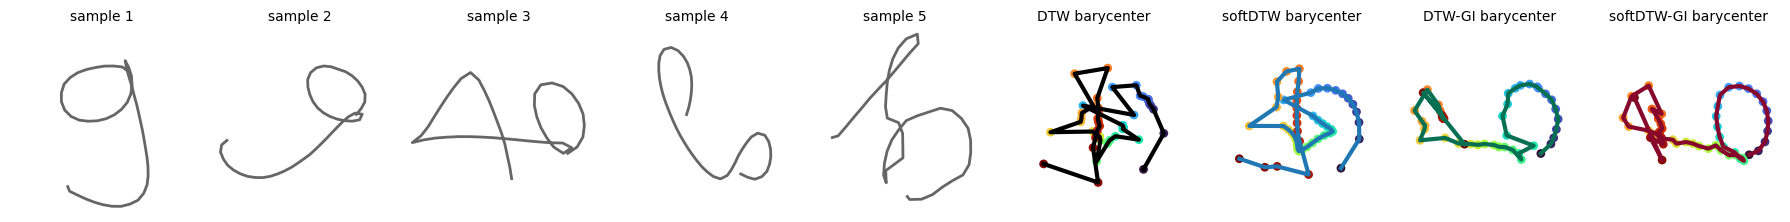

In [142]:
plot_samples_and_barycenters(
    samples=g_data,
    bary_dtw_gi=bary_dtw_gi_g[0],
    bary_dtw=bary_g_dtw,
    bary_softdtw=bary_soft_g,
    bary_softdtw_gi=bary_g,
)
